In [1]:
import json
from matplotlib import pyplot as plt
import datetime as dt
import pandas as pd
import copy
import numpy as np
from tensorflow import keras

plt.rcParams["figure.figsize"] = (40, 20)

In [3]:
#https://api.open-meteo.com/v1/forecast?latitude=53.54&longitude=9.98&past_days=92&hourly=windspeed_10m,winddirection_10m&windspeed_unit=kn
forecast = json.load(open("forecast.json"))
#https://archive-api.open-meteo.com/v1/era5?latitude=53.54&longitude=9.98&start_date=2023-01-01&end_date=2023-04-09&hourly=windspeed_10m,winddirection_10m&windspeed_unit=kn
historical = json.load(open("historical.json"))

forecast_datetime = forecast['hourly']['time']
historical_datetime = historical['hourly']['time']

In [7]:
def json2Dict(jsonVal : dict) -> dict:
    '''Format the open-meteo dict to local format'''
    formated_dict = {}
    for i in range(len(jsonVal['hourly']['time'])):
        formated_dict[jsonVal['hourly']['time'][i]] = [jsonVal['hourly']['windspeed_10m'][i], jsonVal['hourly']['winddirection_10m'][i]]

    return formated_dict

forecast_dict = json2Dict(forecast)
historical_dict = json2Dict(historical)

In [7]:
#Avoid datatime mismatches
time_intersection = set(forecast_datetime) & set(historical_datetime)

#Map the wind speed forecasts and true historical values
forecast_and_historical = {}
for ct in time_intersection:
    if ct not in forecast_dict or ct not in historical_dict: continue
    vls = copy.copy(historical_dict[ct])
    vls.extend(forecast_dict[ct])
    forecast_and_historical[dt.datetime.strptime(ct,'%Y-%m-%dT%H:%M') ] = vls



In [8]:
forecast_and_historicalDf = pd.DataFrame.from_dict(forecast_and_historical, orient='index')
forecast_and_historicalDf.columns = ['hist_speed', 'hist_direction', 'forecast_speed', 'forecast_direction']
forecast_and_historicalDf = forecast_and_historicalDf.dropna()
forecast_and_historicalDf = forecast_and_historicalDf.sort_index()

<Axes: >

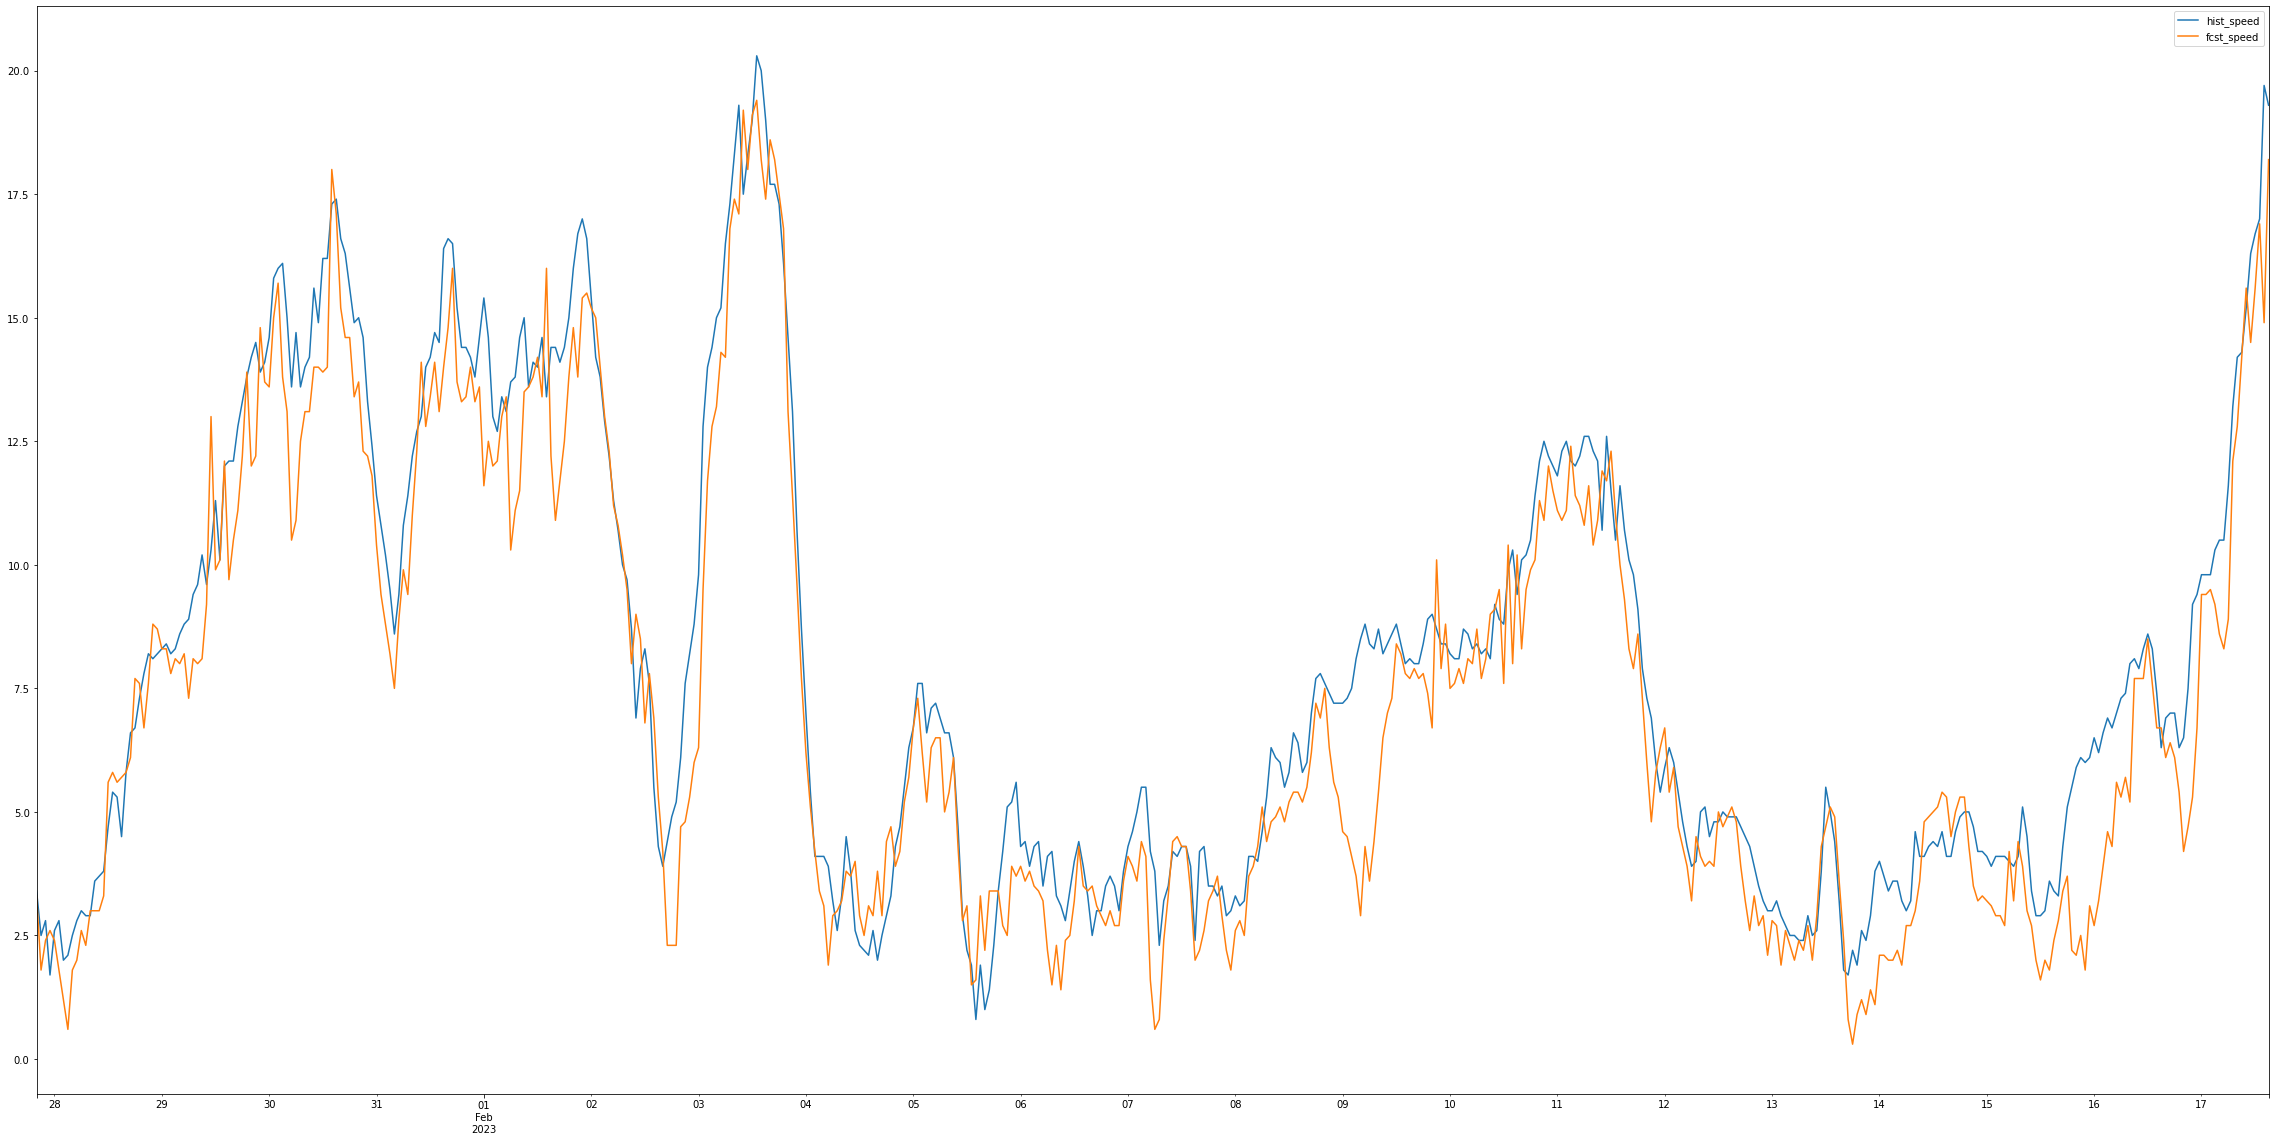

In [92]:
forecast_and_historicalDf[['hist_speed', 'forecast_speed']].iloc[500:1000].plot()

In [182]:
# Load the data into a Pandas DataFrame
data = copy.copy(forecast_and_historicalDf[['forecast_speed', 'hist_speed']])

# Split the data into input and output sequences
window_size = 4
X = []
y = []
for i in range(0, len(data) - window_size-1):
    #Look ahead (+1) for forecasts to include the forecast for the next hour
    frcst_values = data.iloc[i+1:i+window_size+1].values[:,0]
    hist_values = (data.iloc[i:i+window_size].values[:,1])

    training_sample = np.vstack((frcst_values,hist_values))

    X.append(training_sample.transpose()) #data.iloc[i:i+window_size].values)
    y.append(data.iloc[i+window_size])
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size, 1]
X_test, y_test = X[train_size:], y[train_size:, 1]

X_forecast_test = data['forecast_speed'].values[train_size+window_size:-1]
print(f'MSE historical forecasts: {((X_forecast_test - y_test)**2).sum() / len(X_forecast_test):0.2f}', )



MSE historical forecasts: 3.52


In [184]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.LSTM(units=8, input_shape=(window_size, 2)),
    keras.layers.Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=70, batch_size=16, verbose=0, validation_data=(X_test, y_test))

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test, verbose=0)
print('MSE test set:', mse)

# Make predictions on the testing set
preds = model.predict(X_test)


MSE test set: 0.6724468469619751
20/20 [==============================] - 0s 996us/step


In [185]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 8)                 352       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


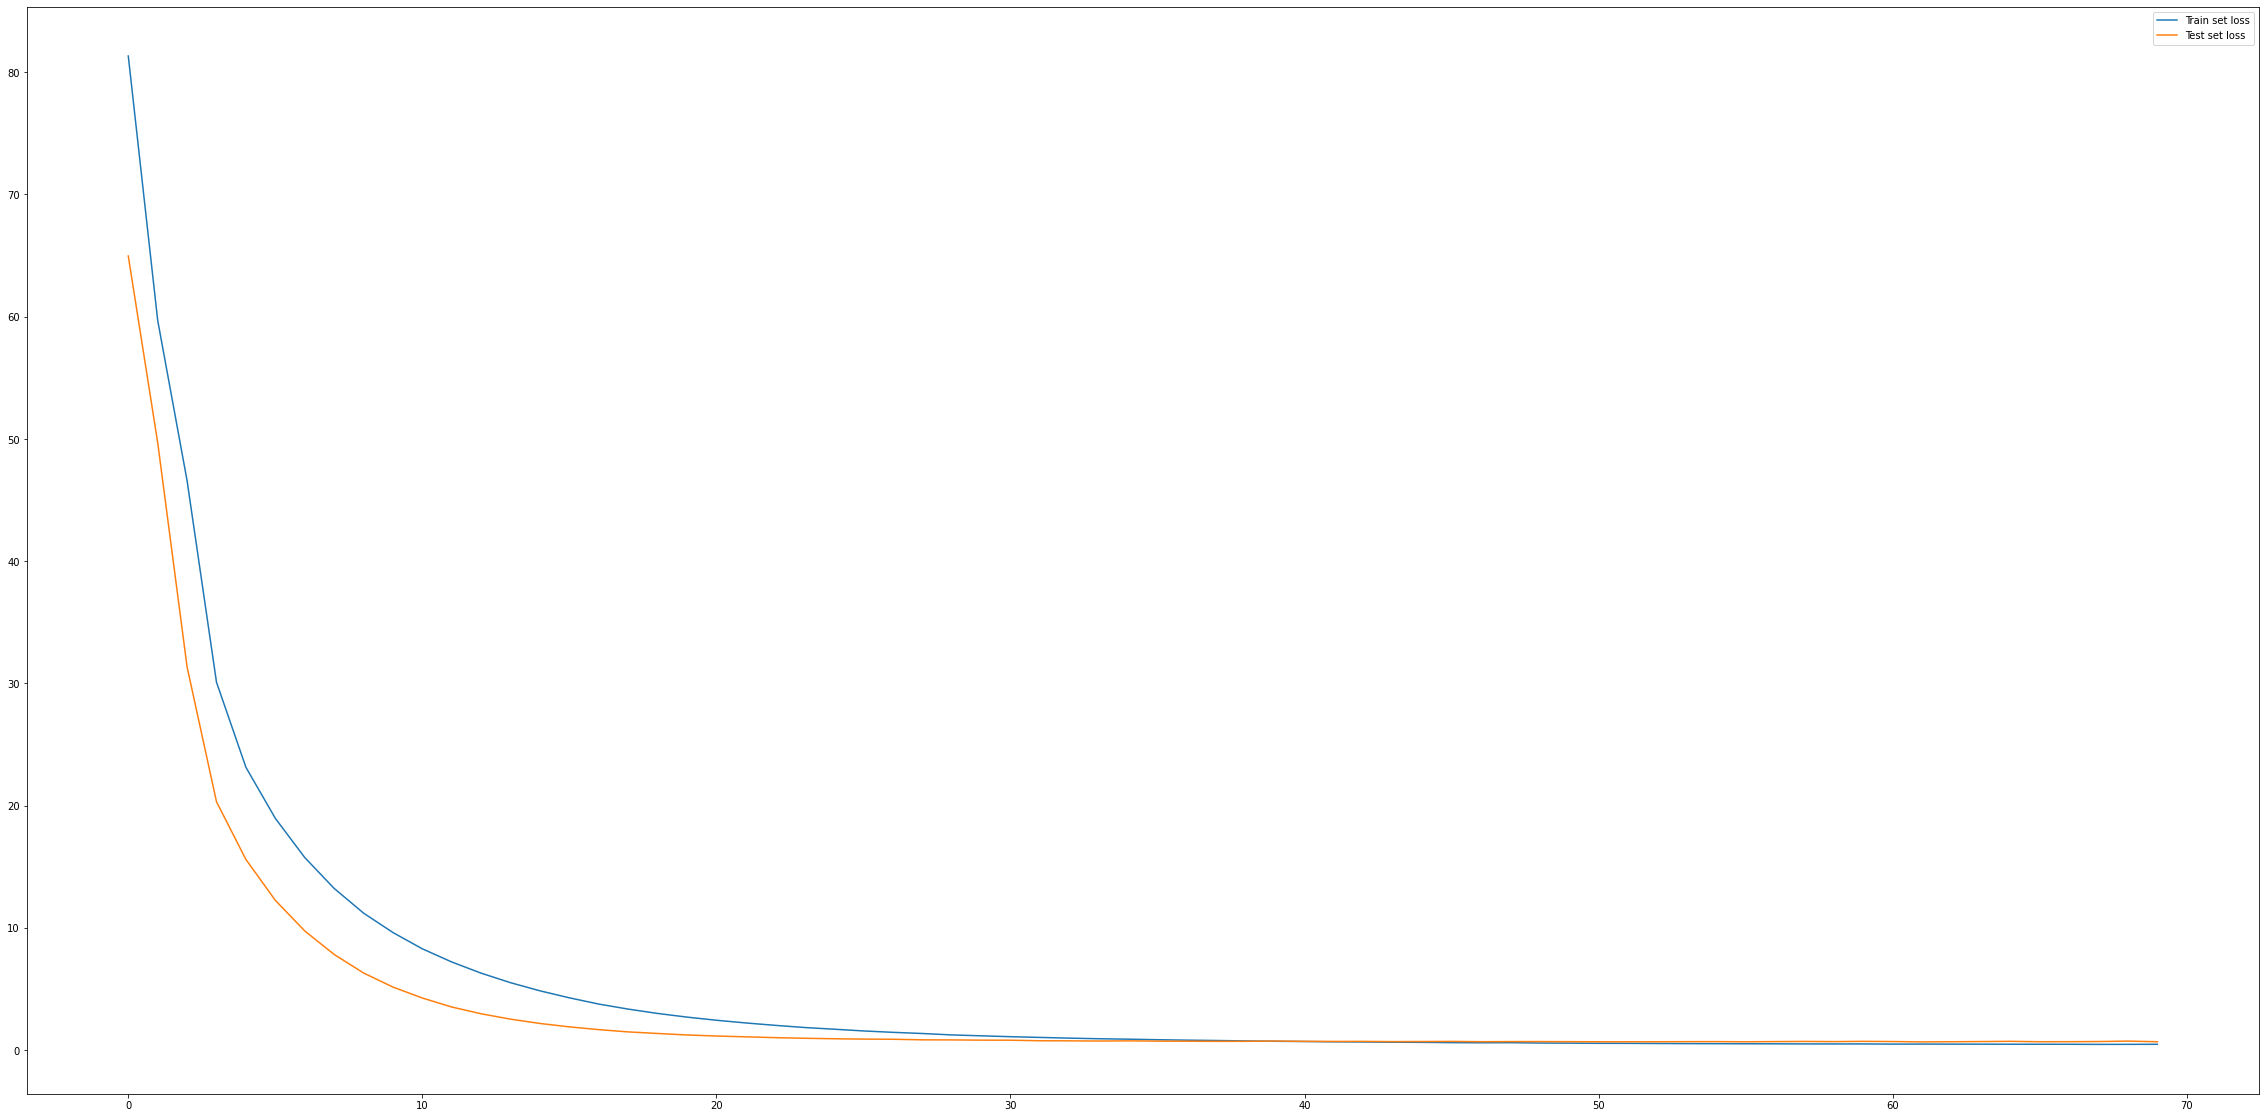

In [186]:
plt.plot(history.history['loss'], label='Train set loss')
plt.plot(history.history['val_loss'], label='Test set loss')
plt.legend()
plt.show()

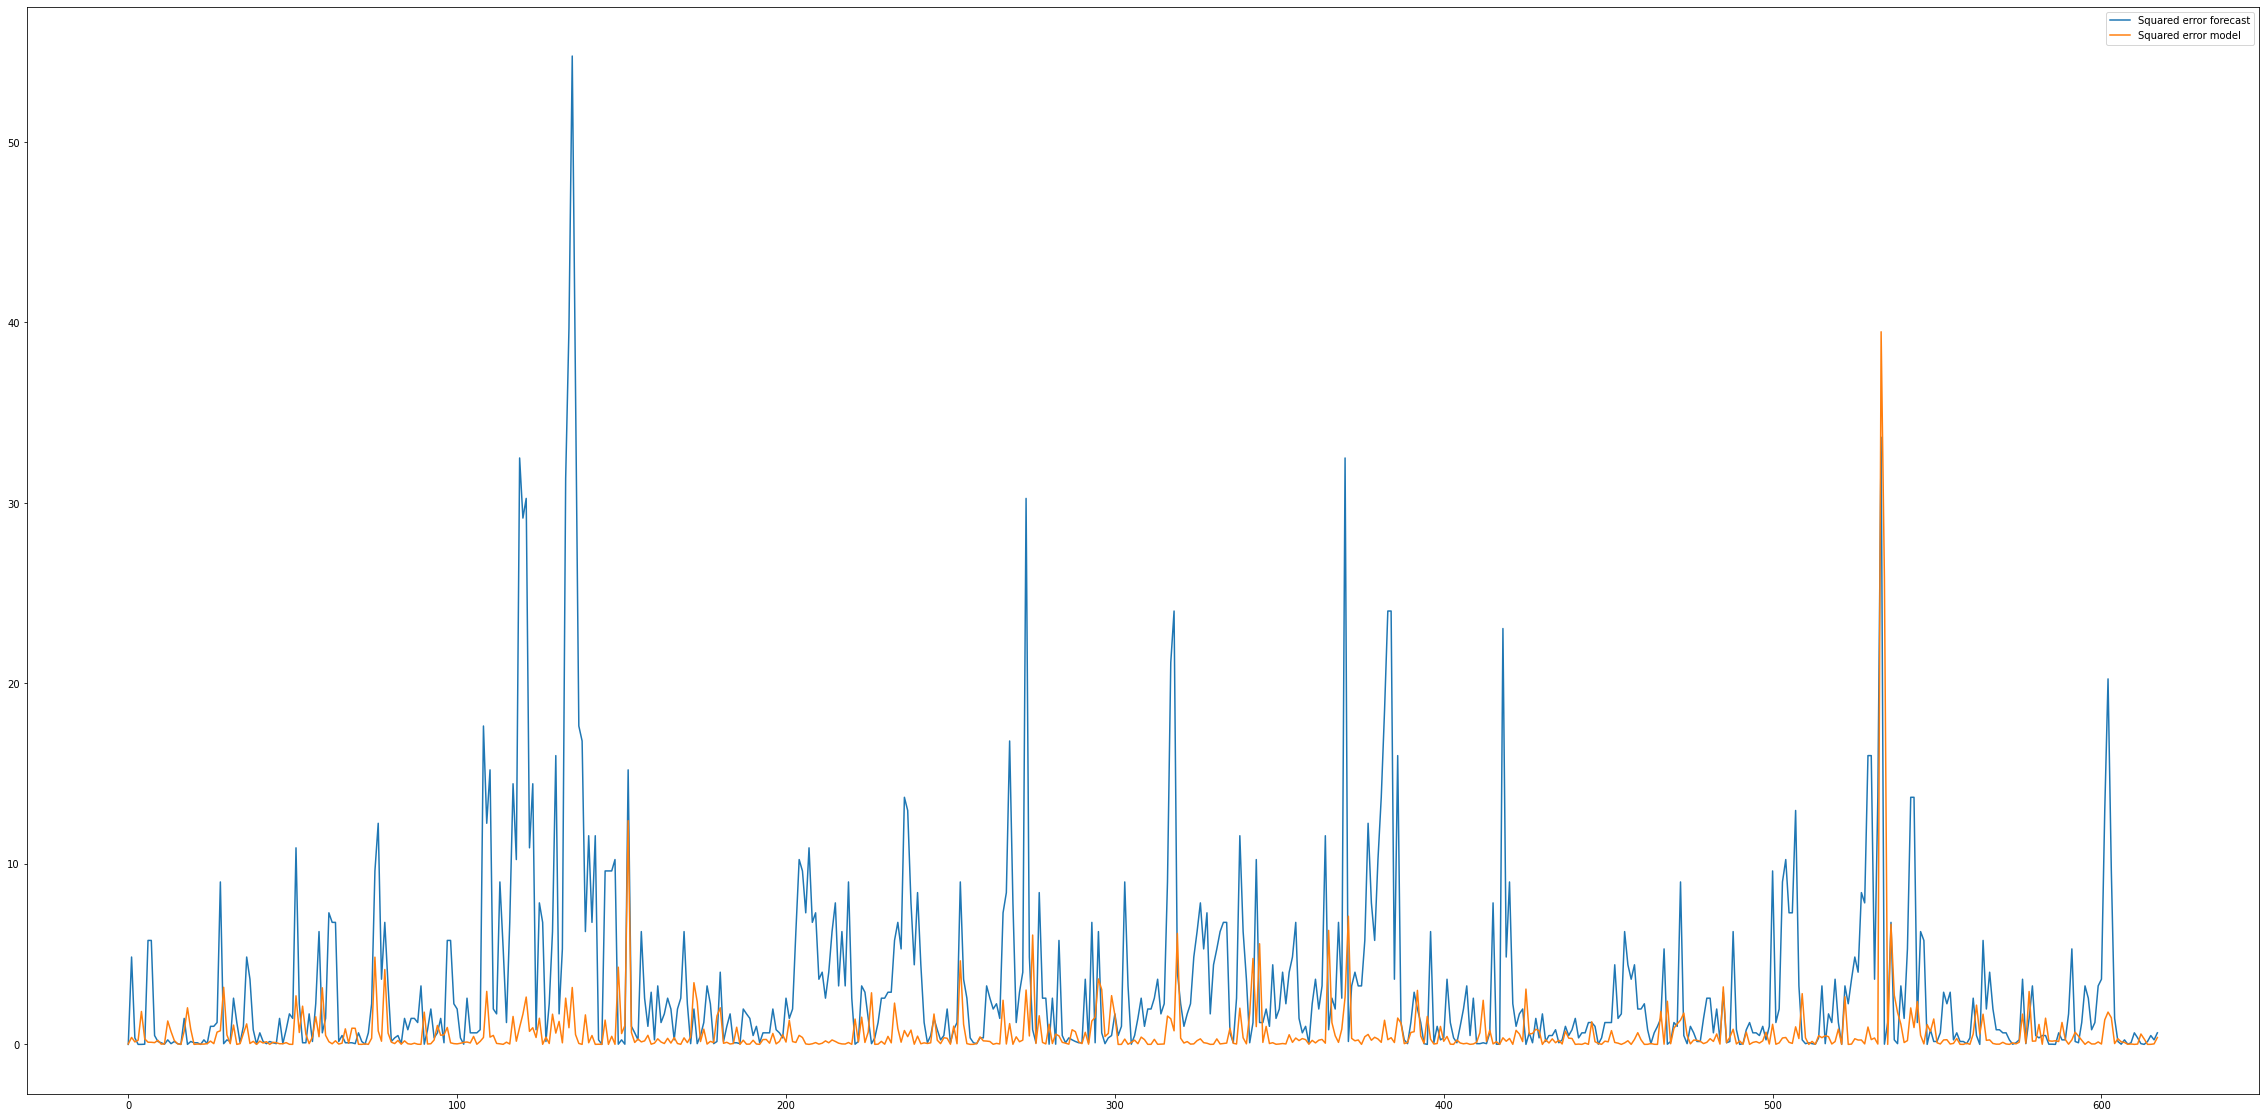

MSE: 0.6724468469619751
20/20 [==============================] - 0s 1ms/step


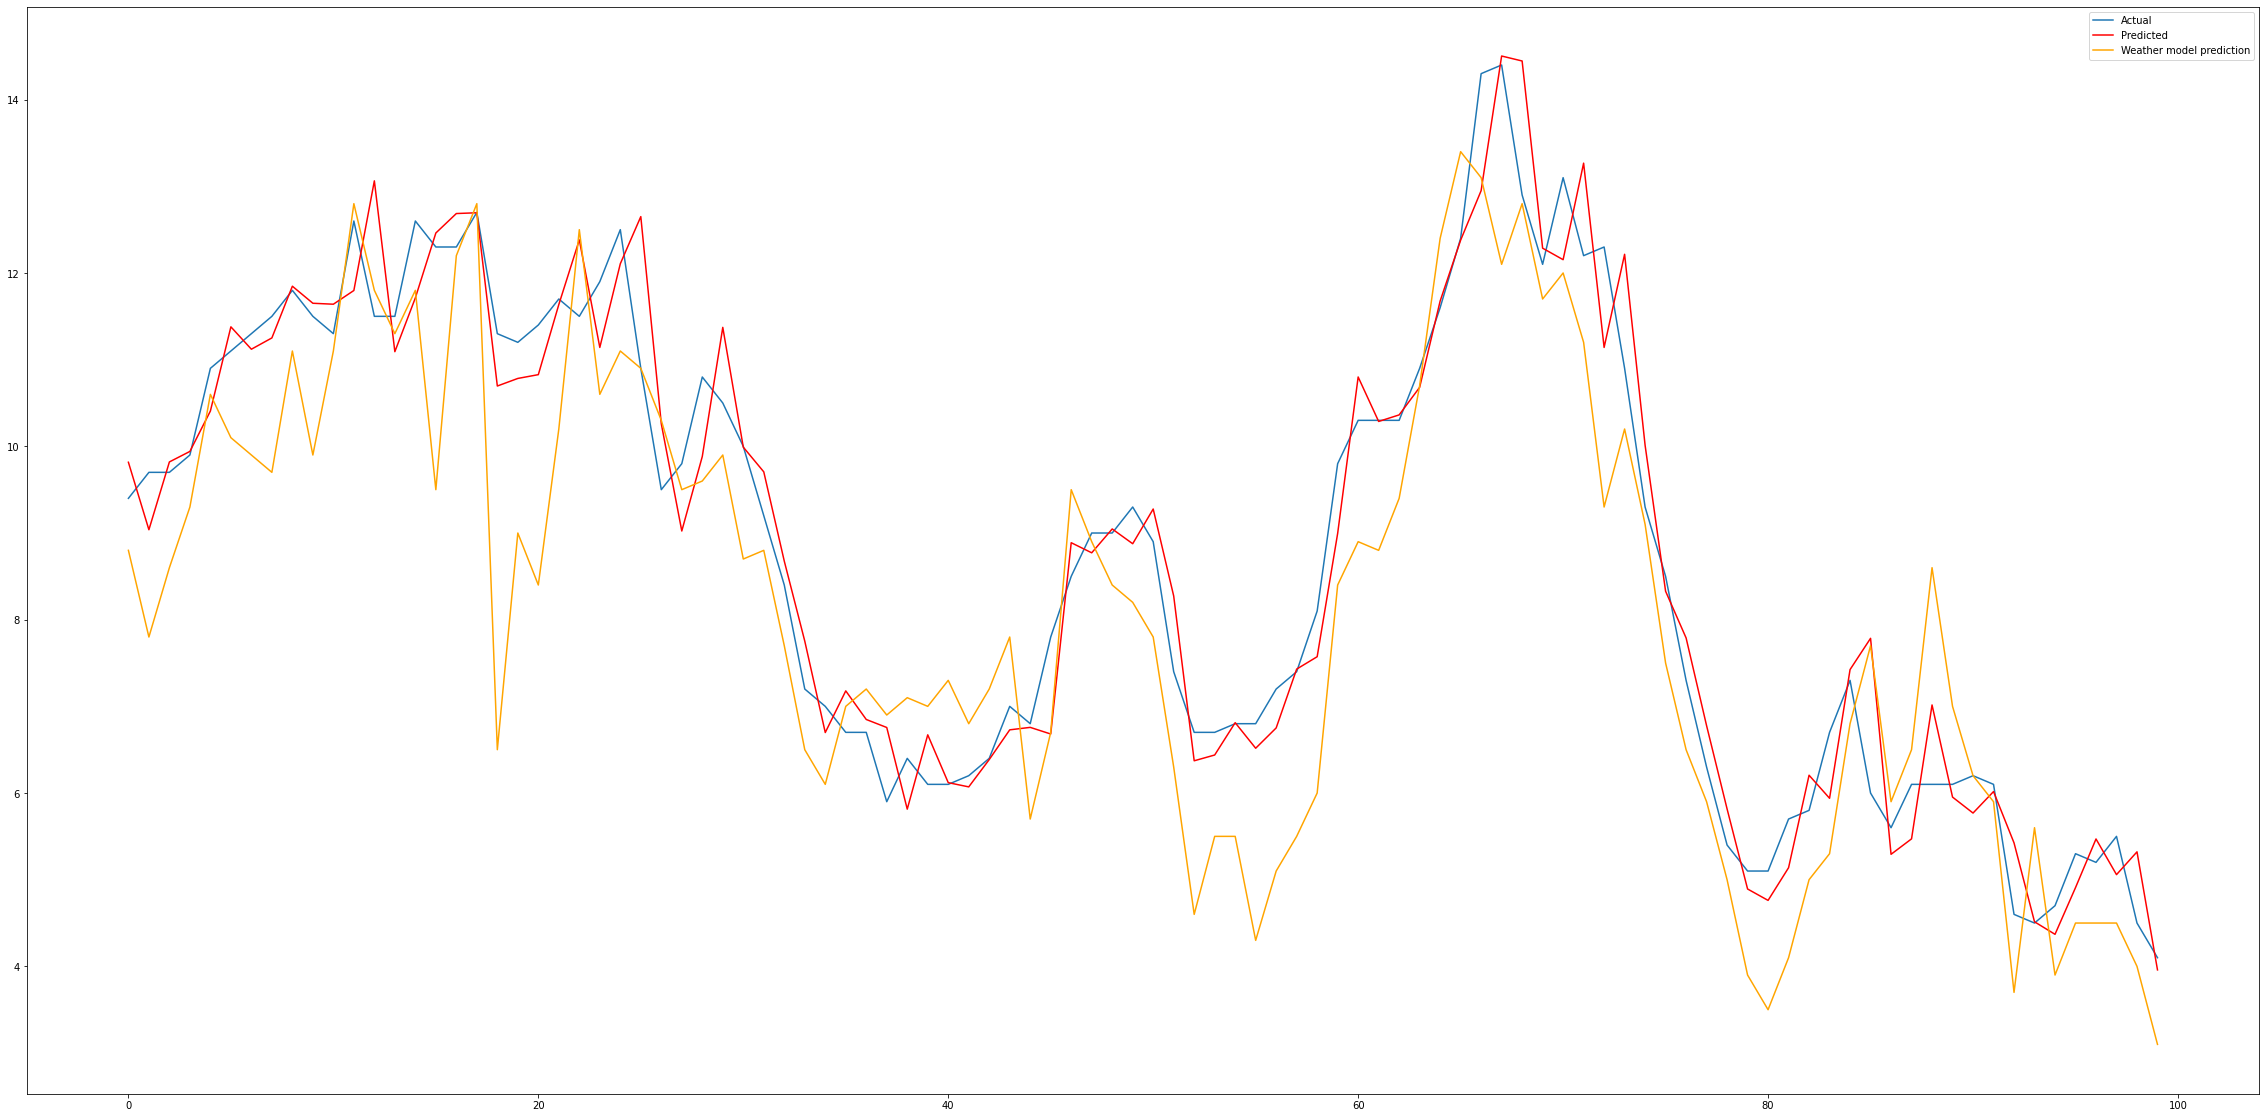

In [198]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test, verbose=0)
print('MSE:', mse)

# Make predictions on the testing set
preds = model.predict(X_test)

test_samples = 200

#plt.scatter(np.arange(len(X_forecast_test[:test_samples])), X_forecast_test[:test_samples],  marker='^')
plt.plot(y_test[:test_samples], label='Actual')
#plt.bar(np.arange(len(X_forecast_test[:test_samples])), y_test[:test_samples], label='Actual')
plt.plot(preds[:test_samples], label='Predicted',  color='red')
plt.plot(X_forecast_test[:test_samples],  label='Weather model prediction', color='orange')
plt.legend()
plt.show()

In [ ]:
plt.plot((X_forecast_test[:test_samples] - y_test[:test_samples])**2, label='Squared error forecast')
#plt.plot([((X_forecast_test[:test_samples] - y_test[:test_samples])**2).mean() for x in range(test_samples)])
plt.plot((preds[:test_samples].flatten() - y_test[:test_samples])**2,  label='Squared error model')
#plt.plot([((preds[:test_samples].flatten() - y_test[:test_samples])**2).mean() for x in range(test_samples)])

plt.legend()
plt.show()